<a href="https://colab.research.google.com/github/henselrj/UMDAOSC650-Hensel/blob/main/HW3_Final_(With_Optimization_Results).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Initialization
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [14]:
# Fixing Seed
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '123'

In [15]:
# Uploading Data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('PALMO_dataset_formatted.csv')

Saving PALMO_dataset_formatted.csv to PALMO_dataset_formatted (1).csv


In [16]:
df = df.dropna()
scaler = StandardScaler()
df[['cl', 'cd', 'cm']] = scaler.fit_transform(df[['cl', 'cd', 'cm']])
df['cl_cd'] = df['cl'] / df['cd']

<ipython-input-16-21ec346ef07e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['cl', 'cd', 'cm']] = scaler.fit_transform(df[['cl', 'cd', 'cm']])
<ipython-input-16-21ec346ef07e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_cd'] = df['cl'] / df['cd']


In [17]:
df['NACA_code'] = (
    df['Camber'].astype(int).astype(str).str.zfill(1) +
    df['Camber_Location'].astype(int).astype(str).str.zfill(1) +
    df['Thickness'].astype(int).astype(str).str.zfill(2)
)

In [18]:
unique_naca = sorted(df['NACA_code'].unique())
naca_map = {v: i for i, v in enumerate(unique_naca)}
df['NACA_class'] = df['NACA_code'].map(naca_map)

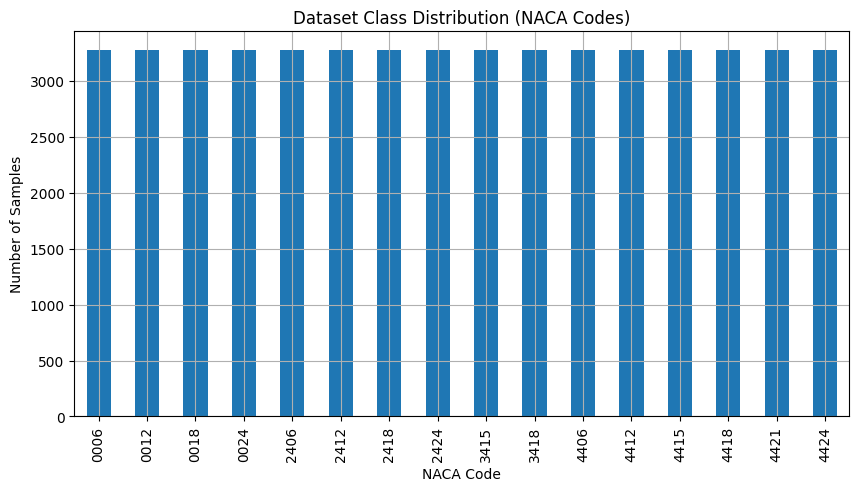

NACA_code
0006    3279
0012    3280
0018    3280
0024    3280
2406    3280
2412    3280
2418    3280
2424    3280
3415    3280
3418    3279
4406    3280
4412    3280
4415    3280
4418    3280
4421    3280
4424    3280
Name: count, dtype: int64


In [19]:
naca_counts = df['NACA_code'].value_counts().sort_index()

naca_counts.plot(kind='bar', figsize=(10,5), title='Dataset Class Distribution (NACA Codes)')
plt.xlabel('NACA Code')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

print(naca_counts)

In [20]:
X = df[['cl', 'cd', 'cm']].values
y = df['NACA_class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
y_train_oh = keras.utils.to_categorical(y_train, num_classes=len(naca_map))
y_test_oh = keras.utils.to_categorical(y_test, num_classes=len(naca_map))

In [22]:
model = keras.Sequential()
model.add(keras.Input(shape=(X.shape[1],)))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dense(320, activation='relu'))

model.add(layers.Dense(len(naca_map), activation='softmax'))

In [23]:
from keras.losses import CategoricalFocalCrossentropy

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005227),
    loss=CategoricalFocalCrossentropy(gamma=3.0, alpha=0.5),
    metrics=['accuracy']
)

In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [25]:
history = model.fit(
    X_train,
    y_train_oh,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2000 - loss: 0.8489 - val_accuracy: 0.3530 - val_loss: 0.5252 - learning_rate: 5.2270e-04
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3647 - loss: 0.5030 - val_accuracy: 0.4221 - val_loss: 0.4131 - learning_rate: 5.2270e-04
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4315 - loss: 0.4085 - val_accuracy: 0.4596 - val_loss: 0.3592 - learning_rate: 5.2270e-04
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4726 - loss: 0.3583 - val_accuracy: 0.4892 - val_loss: 0.3256 - learning_rate: 5.2270e-04
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5026 - loss: 0.3244 - val_accuracy: 0.5151 - val_loss: 0.3012 - learning_rate: 5.2270e-04
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5267 - loss: 0.2992 - val_accuracy: 0.5397 - val_loss: 0.2819 - learning_rate: 5.2270e-04
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/s

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [27]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [28]:
inv_naca_map = {v: k for k, v in naca_map.items()}

In [29]:
print("\nNACA Code Classification Report:")
print(classification_report(y_test, y_pred, target_names=[inv_naca_map[i] for i in range(len(naca_map))]))


NACA Code Classification Report:
              precision    recall  f1-score   support

        0006       0.82      0.91      0.86       619
        0012       0.84      0.71      0.77       660
        0018       0.80      0.76      0.78       633
        0024       0.78      0.83      0.81       606
        2406       0.79      0.78      0.79       627
        2412       0.74      0.66      0.70       679
        2418       0.67      0.78      0.72       652
        2424       0.78      0.71      0.74       687
        3415       0.55      0.49      0.52       656
        3418       0.65      0.61      0.63       682
        4406       0.80      0.92      0.85       639
        4412       0.77      0.70      0.73       696
        4415       0.78      0.69      0.73       648
        4418       0.62      0.73      0.67       665
        4421       0.66      0.66      0.66       685
        4424       0.70      0.79      0.74       662

    accuracy                           0.73   

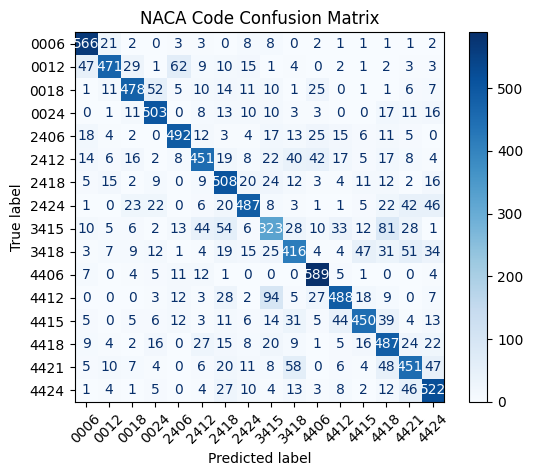

In [30]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_naca_map[i] for i in range(len(naca_map))])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("NACA Code Confusion Matrix")
plt.show()

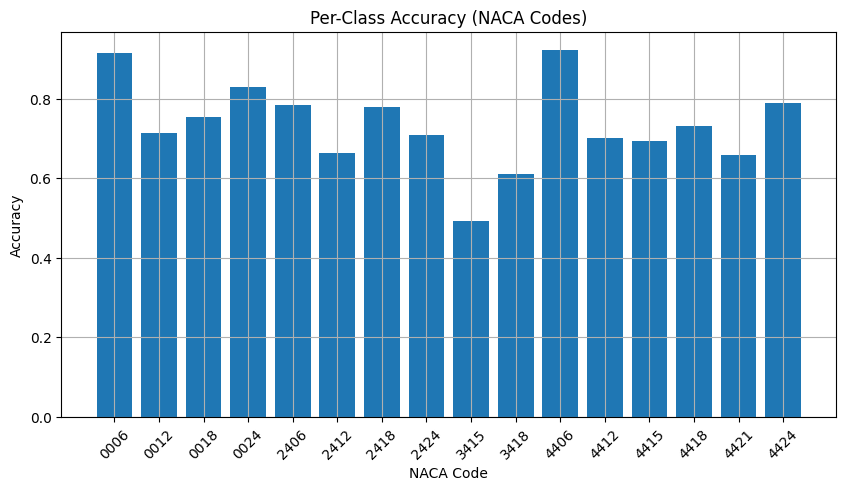

In [33]:
class_accuracies = []
for cls in np.unique(y_test):
    cls_mask = (y_test == cls)
    cls_acc = np.mean(y_pred[cls_mask] == y_test[cls_mask])
    class_accuracies.append(cls_acc)

plt.figure(figsize=(10,5))
plt.bar([inv_naca_map[i] for i in np.unique(y_test)], class_accuracies)
plt.xticks(rotation=45)
plt.title("Per-Class Accuracy (NACA Codes)")
plt.xlabel("NACA Code")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

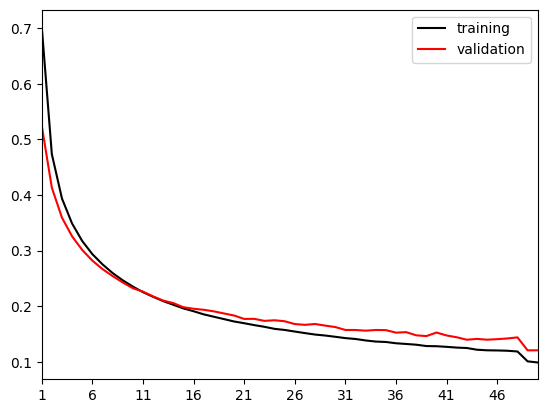

In [32]:
plt.xlim([1,50])
plt.plot(range(1,51), history.history['loss'], c='k', label='training')
plt.plot(range(1,51), history.history['val_loss'], c='r', label='validation')
plt.xticks(range(1, 51, 5))  # Set ticks at every integer from 0 to 19
plt.legend()
plt.show()